# JAX for Scaling Artificial Life Tutorial (ALIFE 2024)

In this Colab we will highlight the core features of JAX that are useful for scaling Artificial Life research and projects.

Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
# @title This is to add a title to a code cell.
# @markdown You can add extra text here. Below: print what accelerator you are using.
# @markdown Only works if you are using nvidia gpus.
!nvidia-smi

In [ ]:
# @title Imports

import jax
import jax.numpy as jp # sometimes it is imported as jnp

import numpy as np

print("Devices used by JAX:", jax.devices())

## JAX vs numpy

In [ ]:
# Creating specific arrays is the same as in numpy.
a_jax = jp.ones([2,3])
a_np = np.ones([2,3])
print(a_jax, type(a_jax))
print(a_np, type(a_np))

In [ ]:
b_jax = jp.array([[1,2,3],[4,5,6]])
b_np = np.array([[1,2,3],[4,5,6]])

print(a_jax + b_jax)
print(a_np + b_np)

In [ ]:
# jp arrays can perform the same operations you would expect from np.
bn = 4
cn = 3
x = jp.ones([bn, cn])
x2 = x * 2
print("scalar mul", x2)
print("mul", x * x2)
print("div", x / x2)
print("transpose", x.T)
print("matrix multiplication", x @ x.T)
print("einsum :) (this is equivalent to x @ x.T)", jp.einsum("io,jo->ij",x,x))
# chances are that if the function exists in np, it exists too in jp.

JAX uses a functional paradigm. This is enforced by requiring all inputs to be IMMUTABLE (they do smart casting for you whenever possible).

Therefore, all JAX arrays are immutable! This is different from numpy.

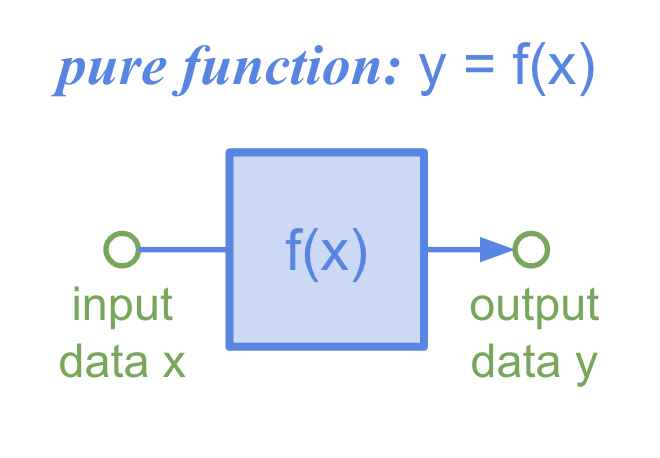

In [ ]:
# In numpy, you can easily modify an array:
print("in numpy")
a_np = np.zeros([4,3])
print(a_np)
a_np[1,:] = np.array([1,2,3])
print(a_np)

In [ ]:
print("in jp")
# You cannot do the same in jp. Instead, you create a new array.
a_jp = jp.zeros([4, 3])
print(a_jp)
try:
  a_jp[1,:] = jp.array([1,2,3])
except TypeError as err:
  print(err)

In [ ]:
b_jp = a_jp.at[1].set(jp.array([1,2,3]))
print(b_jp)
print("a_jp, of course, stays the same", a_jp)

# you can do more than just "set". You can add, multiply, divide, etc.
# see this for reference: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax.numpy.ndarray.at

randomness, and random initialization, is again handled differently.

JAX is functional! So, you have to pass a random key to every function that needs randomness. This is perfect for preserving reproducibility of experiments.

In [ ]:
print("in numpy")
np.random.seed(137)
m = 1
sd = 3
a_np = np.random.normal(m, sd, (2,3))
print(a_np)
b_np = np.random.normal(m, sd, (2,3))
print(b_np)

In [ ]:
print("in JAX")
import jax.random as jr
key = jr.PRNGKey(137)
a = jr.normal(key, (2,3)) * sd + m
print(a)
print("reusing the same key gives the same result")
b = jr.normal(key, (2,3)) * sd + m
print(b)

In [ ]:
print("so, you split the key. here is the canon approach:")
key = jr.PRNGKey(137)
ku, key = jr.split(key)
a = jr.normal(ku, (2,3)) * sd + m
print(a)
ku, key = jr.split(key)
b = jr.normal(ku, (2,3)) * sd + m
print(b)

## Accelerating functions: for loops and just-in-time compilation

In [ ]:
import time
import matplotlib.pyplot as plt

# say that you want to compute a function many, many times.
def geometric_step_f(x, i):
  return x + jp.pow(0.5, i)

n_reps = 1000
start = time.time()
x = 0
log = []
for i in range(n_reps):
  x = geometric_step_f(x, i)
  log.append(x)

print(x, f"time: {time.time() - start} secs")
plt.plot(log)
plt.show()


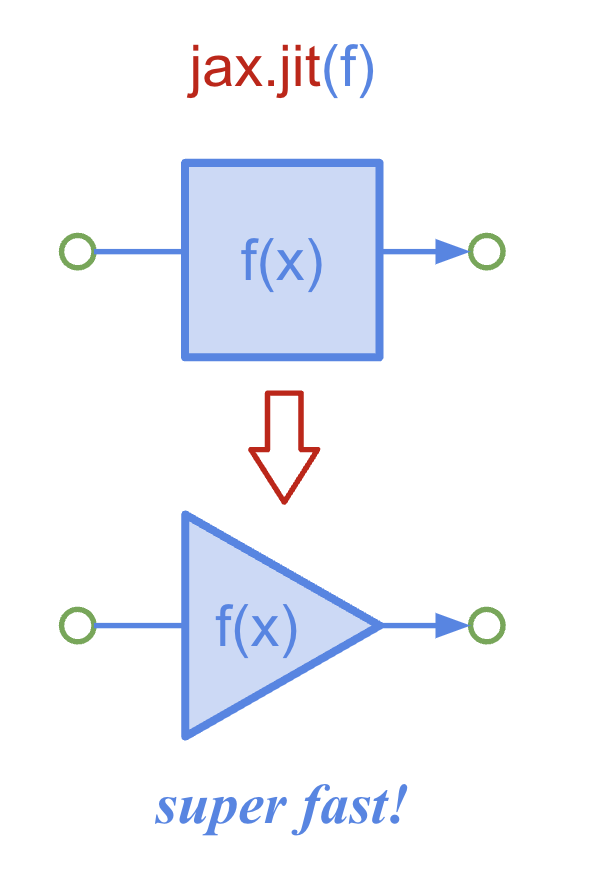

In [ ]:
# first improvement: jit the function!
@jax.jit
def geometric_step_f(x, i):
  print("this is printed only during compilation")
  print("note that both inputs are jax arrays. Even i.")
  print(x.dtype, i.dtype)
  return x + jp.pow(0.5, i)

# it becomes a bit slow if you add a zero here.
n_reps = 1000
start = time.time()
# note: if you don't use the right type - say, int - it compiles TWICE!
x = jp.array(0.)
log = []
for i in range(n_reps):
  x = geometric_step_f(x, i)
  log.append(x)

print(x, f"time: {time.time() - start} secs")
plt.plot(log)
plt.show()

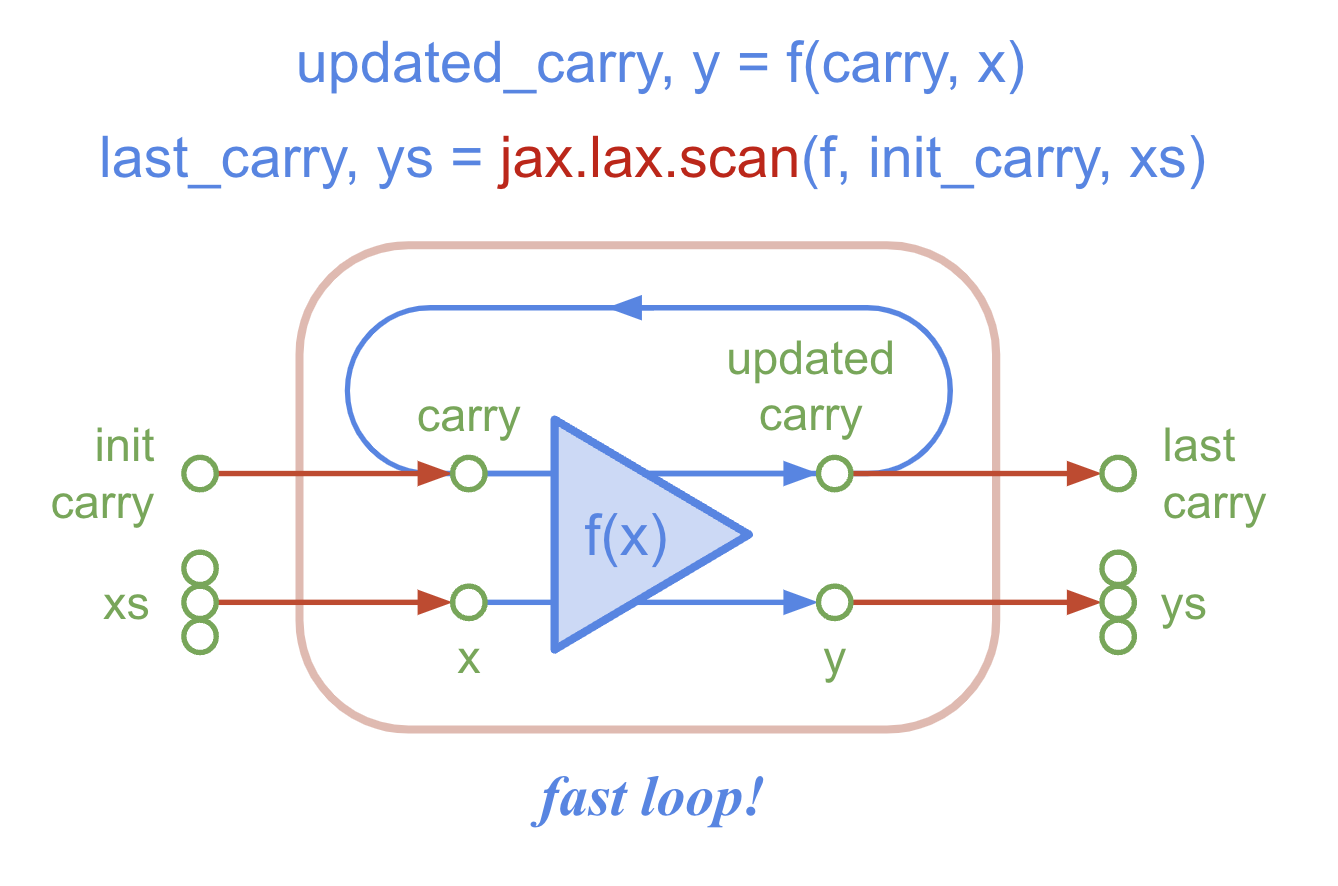

In [ ]:
# second improvement: compile the for loop!
#@jax.jit You don't need to compile it: scan compiles!
def geometric_step_f(carry, i):
  print("this is printed only during compilation")
  print("note that both inputs are jax arrays. Even i.")
  x = carry
  print(x.dtype, i.dtype)
  res = x + jp.pow(0.5, i)
  # return a carry, and any 'outputs' that you care about for each step.
  # in this case, we want to keep track of the result to log it, so:
  carry = res
  return carry, res

# note: this should be already faster. But due to variabilities in wall time,
# you can convince yourself by how much faster it is by adding a zero in n_reps
n_reps = 1000
start = time.time()
# note: if you don't use the right type - say, int - it compiles TWICE!
x = jp.array(0.)
x, log = jax.lax.scan(geometric_step_f, x, jp.arange(n_reps))
# equivalently:
# x, log = jax.lax.scan(geometric_step_f, x, length=n_reps)

print(x, f"time: {time.time() - start} secs")
plt.plot(log)
plt.show()

## JIT compilation with inputs that are not numeric variables

In [ ]:
# suppose that you wanted to create a function that can handle many operations.
# This happens often in larger code bases.
num_compilations = 0
print("Not jitted")
def complex_f(a,b,op):
  # note the blasphemy! This is stateful :)
  # but it is okay because it will NOT be stateful after being compiled.
  global num_compilations
  num_compilations += 1
  print(f"compilation number {num_compilations}")
  return op(a,b)

a = jp.full((5,), 2.)
b = jp.full((5,), 1.)
op1 = lambda a,b: a + b
op2 = lambda a,b: a - b
print(complex_f(a, b, op1))
print(complex_f(a, b, op2))

In [ ]:
print("jitting that function normally doesn't work")
try:
  res = jax.jit(complex_f)(a, b, op1)
except TypeError as err:
  print(err)

In [ ]:
# instead you define some inputs as static:
jit_complex_f = jax.jit(complex_f, static_argnames=["op"])
print(jit_complex_f(a,b, op1))
print("executing with the exact same op reference does not trigger recompilation!")
print(jit_complex_f(a,b, op1))
print("but with a different op, it gets recompiled.")
print(jit_complex_f(a,b, op2))

In [ ]:
print("Here is how you would write it from scratch:")
from functools import partial

@partial(jax.jit, static_argnames=["op"])
def jit_complex_f(a,b,op):
  # omitting the blasphemy here.
  return op(a,b)

print(jit_complex_f(a,b, op1))
print(jit_complex_f(a,b, op2))

In [ ]:
# if you want to have conditionals in the compilation of a function, you should
# do the same as before.

def cond_f(a,b,is_add):
  print("Pious compile check (not stateful).")
  if is_add:
    return a + b
  else:
    return a - b

print("This works without jitting, but it compiles every time.")
print(cond_f(a, b, True))
print(cond_f(a, b, False))

print("jitting with static_argnames here works as well.")
jit_cond_f = jax.jit(cond_f, static_argnames=["is_add"])
print(jit_cond_f(a, b, True))
print(jit_cond_f(a, b, True))
print(jit_cond_f(a, b, False))
print("These functions are compiled when the boolean changes.")
print("We will see later how to handle this dynamically.")


## Vectorising and parallelising

vmap makes writing scalable code trivial!

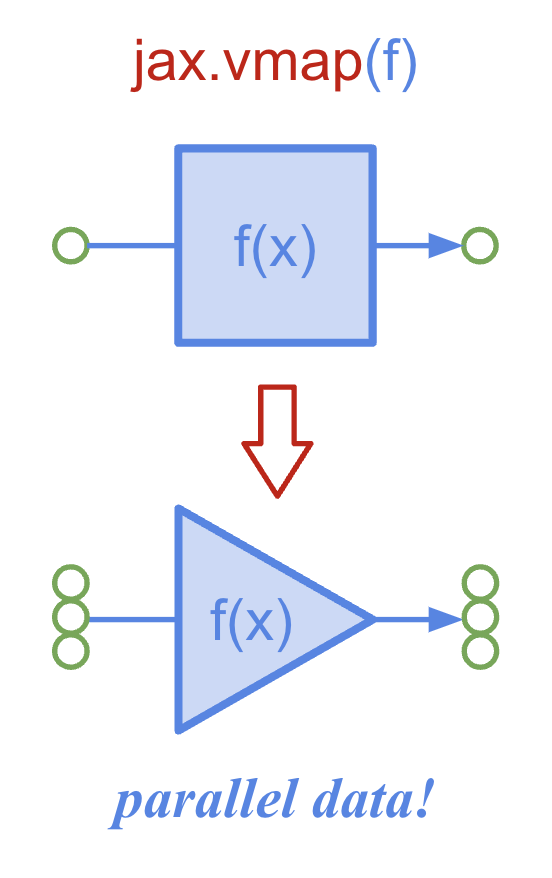


In [ ]:
# The basics of vmap: You can add dimensions to handle parallel executions.

def f(w, x):
  # note that i inverted the direction of matmul this time.
  return x @ w

x = jp.ones([2,3])
w = jp.ones([3,4])
print(f(w, x).shape)

In [ ]:
# what if we wanted to perform this operation with an extra batch size?
bs = 5
b_x = jp.ones([5,2,3])
b_w = jp.ones([5,3,4])
# fun fact, ONLY BECAUSE I AM USING '@', this actually would work:
# print(f(b_w, b_x).shape)
# This is only because '@' is smart.

# you can "vectorize" the operation:
print(jax.vmap(f)(b_w, b_x).shape)

In [ ]:
# but actually, this also allows you to add a batch size ONLY to x, while
# keeping w the same as before.
print(jax.vmap(partial(f, w=w))(x=b_x).shape)

This approach is wonderful. You can think about the individual pieces and then vectorize them.

For instance, if you want a cell in a 2d grid to perform an operation, you can:
```python
def cell_f(neighbor_state):
  # care only about yourself.
  return something
```

And then you simply vmap twice :)
```python
from jax import vmap
grid_f = vmap(vmap(cell_f))
```

In [ ]:
# Suppose that you have a very complex function. Let's say it simulates
# an environment and returns you a fitness.

def fitness_f(env):
  return jp.abs(env).mean()

def simulate_f(key, env):
  # ideally here you do very complex stuff.
  # Could be thousands of lines of code. Trust me :)
  return env * jr.randint(key, env.shape, 0, 10)

@jax.jit
def simulate_and_evaluate_f(key, env):
  env = simulate_f(key, env)
  return fitness_f(env)

env = jp.ones([10])
key = jr.PRNGKey(42)
ku, key = jr.split(key)
print(simulate_and_evaluate_f(ku, env))

In [ ]:
# Now what would happen if I asked you to run this 10000 times?
# The ugly, inefficient, way, would be using a for loop.

start = time.time()
res = []
for i in range(10000):
  ku, key = jr.split(key)
  res.append(simulate_and_evaluate_f(ku, env))
res = jp.array(res)
print(f"took {time.time() - start} secs")
print(res.mean(), res.std())


In [ ]:
# or, you can simply vectorize it!
start = time.time()
res = jax.vmap(partial(simulate_and_evaluate_f, env=env))(jr.split(key, 10000))
print(f"took {time.time() - start} secs")
print(res.mean(), res.std())

pmap makes you parallelize across devices!

pmap has mostly the same interface of vmap, but it has many catches. For instance:


*   All devices you use need to be the same.
*   The leading axis dimension you pass to a pmapped function must be less or equal to the number of devices available.
*   If you plan to use it, [read the documentation!](https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html)

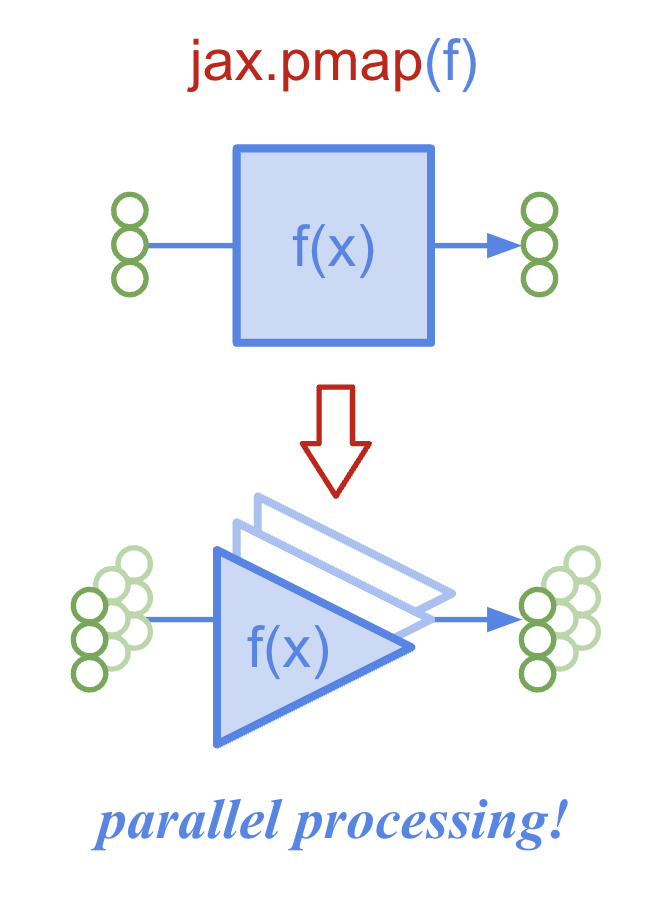


In [ ]:
def f(x):
  return x**2

local_device_count = jax.local_device_count()
print(f"we have {local_device_count} available devices.")

p_f = jax.pmap(f)

print(p_f(jp.arange(local_device_count)))

In [ ]:
try:
  print(p_f(jp.arange(local_device_count+1)))
except ValueError as e:
  print(e)

Extra: Using TPUs adds further complexity, since you can have a total device count, and a local_device count.

In [ ]:
# The total number of TPU cores in the Pod
device_count = jax.device_count()

# The number of TPU cores attached to this host
local_device_count = jax.local_device_count()

# The psum is performed over all mapped devices across the Pod
xs = jp.ones(jax.local_device_count())
# so you can use psum to aggregate results across all replicas.
r = jax.pmap(lambda x: jax.lax.psum(x, 'i'), axis_name='i')(xs)

# Print from a single host to avoid duplicated output
if jax.process_index() == 0:
    print('global device count:', jax.device_count())
    print('local device count:', jax.local_device_count())
    print('pmap result:', r, 'would print device_count local_device_count times')

In practice, researchers use sharding and JAX automatically takes care of figuring out the most efficient computation. If interested, read the following:

*   [Distributed arrays and automatic parallelization](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html)
*   [Introduction to sharded computation](https://jax.readthedocs.io/en/latest/sharded-computation.html)



## Conditionals with compiled functions (jit,scan,vmap,pmap,grad)

In [ ]:
# Suppose you wanted to create a conditional function:
def f(x):
  print("compiling f")
  return x**2 if x > 0 else 0

# this works when not jitted, of course. Albeit very inefficient.
print(f(2))
print(f(-1))

In [ ]:
# but it cannot be jitted!
jit_f = jax.jit(f)
try:
  print(jit_f(2))
except jax.errors.TracerBoolConversionError as e:
  print(e)

The solution is to use [jax.lax.cond](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html).

But beware! it may be wasteful: whenever it is vectorized with vmap, it executes both branches.

In [ ]:
@jax.jit
def f(x):
  print("compiling f")
  return jax.lax.cond(
      x > 0,
      lambda x: x**2, # True
      lambda x: 0, # False
      x)

print(f(2))
print(f(-1))

In [ ]:
# vmapping it makes it wasteful, but still convenient to think about.
x = jp.arange(-5, 6)
print(jax.vmap(f)(x))

On very large code bases, such as Biomaker CA, if you write a jax.lax.cond, you should expect it to execute both branches because eventually you will use a vmap.

In [ ]:
# fixing the previous cond_f to not require two different compilations:
"""It was:
def cond_f(a,b,is_add):
  print("Pious compile check (not stateful).")
  if is_add:
    return a + b
  else:
    return a - b
"""

@jax.jit
def cond_f(a,b,is_add):
  print("Pious compile check (not stateful).")
  return jax.lax.cond(
      is_add,
      lambda: a+b, # True
      lambda: a-b, # False
      ) # no operand is actually needed here. You could pass a and b.

a = jp.full((5,), 2.)
b = jp.full((5,), 1.)

print(cond_f(a, b, True))
print(cond_f(a, b, True))
print(cond_f(a, b, False))

##Dynamic array updates on jitted functions


In [ ]:
x = jp.arange(10)
print(x)

In [ ]:
# at-set works for most cases, even when you jit it.
@jax.jit
def f(x):
  return x.at[3:5].set(-1)

print(f(x))

In [ ]:
# but it doesn't work when the index to start is dynamic.
@jax.jit
def f(x, start):
  return x.at[start:start+2].set(-1)

try:
  print(f(x, 3))
except IndexError as err:
  print(err)

In [ ]:
# you need to use a dynamic update that enforces a fixed size of the update.
@jax.jit
def f(x, start):
  return jax.lax.dynamic_update_slice(
      x, # the array to update
      jp.full((2,), -1), # the values to place starting from start.
      (start,) # the index where we start updating.
  )

print(f"idx {3}", f(x, 3))
print(f"idx {4}",f(x, 4))
# works even here...
print(f"idx {8}",f(x, 8))
print(f"idx {9}",f(x, 9))
print(f"idx {10}",f(x, 10))

In [ ]:
# this can be also multidimensional.
x = jp.ones((4, 4), dtype=jp.int32)
print(x)

def f(x, start_x, start_y):
  return jax.lax.dynamic_update_slice(
      x, # the array to update
      jp.full((2, 3), -1), # the values to place
      (start_x, start_y) # the indexes where we start updating.
  )

print(f(x, 1, 0))

You cannot jit a function with a dynamic SIZE of the update. You always update a fixed size, but you can change the position in the array where it happens.

## grad: in-built differentiation

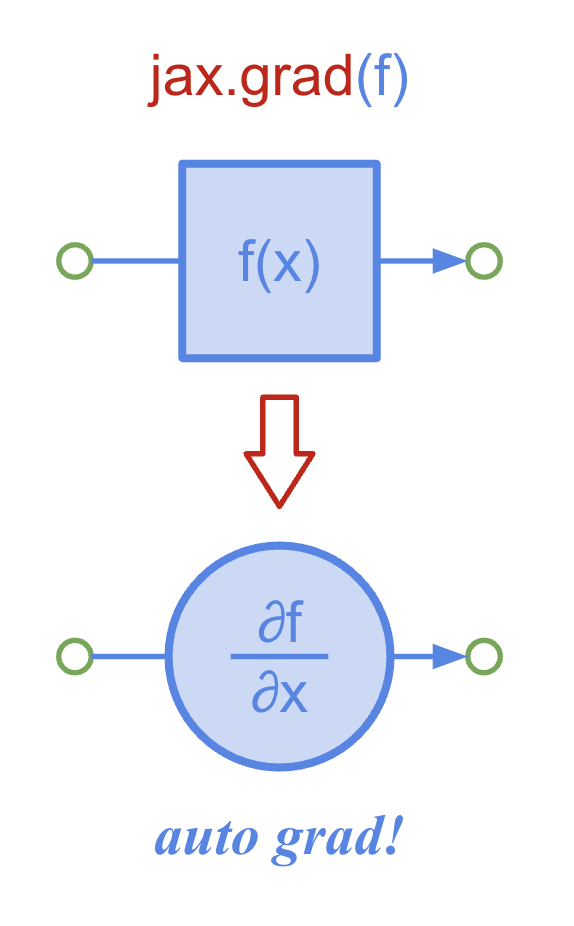


In [ ]:
# Grad is another superpower of JAX. Automatic differentiation!

def f(x):
  return x**2

# note: doesn't matter how complex the function is, as long as it is
# differentiable.
grad_f = jax.grad(f) # grad_f(x): 2x
# remember, the input needs to be a float, not an int!
x = 3.0
print(f(x), grad_f(x))

In [ ]:
# you can also do this together:
print(jax.value_and_grad(f)(x))

In [ ]:
# what if we wanted to compute many gradients?
x = jp.arange(5, dtype=jp.float32)
try:
  grad_f(x)
except TypeError as e:
  print(e)
# The gradient must be one coming from a scalar output!

In [ ]:
# But usually, anyway, complex functions wouldn't work if you simply added a
# dimension. Instead, vectorize!
x = jp.arange(5, dtype=jp.float32)

v_value_and_grad_f = jax.vmap(jax.value_and_grad(f))
print(v_value_and_grad_f(x))

In [ ]:
print("grad only computes gradients for the first input!")
def f(w, x):
  return (x @ w).mean()

x = jp.arange(5, dtype=jp.float32)
w = jp.ones((5, 4))
print(jax.grad(f)(w, x))

So, we usually pass all parameters of a model as the first input (in a tuple or a dict), and all other inputs are non-trainable constants such as data.


### Extra: a typical training loop for linear regression

In [ ]:
key = jr.PRNGKey(137)
indim = 5
outdim = 4
bs = 16

ku, key = jr.split(key)
wt = jr.normal(ku, (indim, outdim))

@jax.jit
def f(w, x):
  # this works as if it was vectorized with vmap.
  return x @ w

def create_batch(key, bs):
  ku, key = jr.split(key)
  x = jr.normal(ku, (bs, indim))
  yt = f(wt, x)
  return x, yt


def loss_f(w, x, yt):
  y = f(w, x)
  return ((y - yt)**2).mean(axis=-1)

def b_loss_f(w, x, yt):
  return jax.vmap(partial(loss_f, w=w))(x=x, yt=yt).mean()

ku, key = jr.split(key)
w = jr.normal(ku, (indim, outdim))

lr = 0.1
@jax.jit
def manual_step_f(w, x, yt):
  grad_f = jax.value_and_grad(b_loss_f)
  l, grad = grad_f(w, x, yt)
  # just because we have only one variable as parameters. Otherwise, we'd have
  # to do this for the entire parameter tree.
  w -= lr * grad
  return l, w

for i in range(300):
  ku, key = jr.split(key)
  x, yt = create_batch(ku, bs)
  l, w = manual_step_f(w, x, yt)
  if i % 10 == 0:
    print(i, l)

In practice, you would use some libraries to construct models, such as Flax or Haiku, and optax for built-in optimizers. So if you are interested, check them out (links below).

### Extra: computing the jacobian instead

Ultimately due to the chain rule, we would be computing the jacobian for intermediate functions anyway. Clearly JAX can do that too.

So, if you wanted to compute the jacobian of a function, just use jax.vjp (backward mode) or jax.jvp (forward mode).

In [ ]:
# VJP: what, if anything, you would use.
x = jp.arange(5, dtype=jp.float32)
y, jac_f = jax.vjp(f,x)
cotangents = jp.ones(5)
print(y)
print(jac_f(cotangents))

In [ ]:
# JVP is forward mode, and it is almost never used.
x = jp.arange(5, dtype=jp.float32)
tangents = (jp.ones(5),)
y, jac = jax.jvp(f, (x,), tangents)
print(y)
print(jac)

Just to be clear what is going on in this toy example: we are actually computing the gradient of EACH INPUT with respect to EACH output and summing them together. Since f was element-wise, it looks like we are doing element-wise gradients, but we are not.

The example below makes it clear:

In [ ]:
def f2(x):
  # triangular matrix
  x_dim = x.shape[-1]
  w = jp.tril(jp.ones([x_dim, x_dim]))
  return x @ w

x = jp.arange(5, dtype=jp.float32)
y, jac_f = jax.vjp(f2,x)
cotangents = jp.ones(5)
print(y)
print(jac_f(cotangents))

In practice, you will almost always just use grad.

## Further ALife-related readings:

*   [micro-NCA training Colab](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_jax.ipynb)
*   [JAX raycasting (rendering complex shapes)](https://google-research.github.io/self-organising-systems/2022/jax-raycast/)
*   [Biomaker CA code base](https://github.com/google-research/self-organising-systems/tree/master/self_organising_systems/biomakerca)

## Useful ALife-related libraries built on top of JAX

I am listing only a subset of what I used. There is a thriving community creating libraries for JAX!

*   Differentiable JAX: [flax](https://flax.readthedocs.io/en/latest/), [haiku](https://dm-haiku.readthedocs.io/en/latest/), [optax](https://github.com/google-deepmind/optax)
*   Particle simulation library: [jax-md](https://github.com/jax-md/jax-md) (stands for molecular dynamics)
*   Evolutionary strategies: [evojax](https://github.com/google/evojax) and [evosax](https://github.com/RobertTLange/evosax)
